# NY Person Trip Predictor

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection
import warnings
import math
import time
warnings.filterwarnings('ignore')

In [2]:
path = "C:/Users/Seant/Desktop/aml_data" #edit this path to change to your path folder
#path = "/Users/weijilim/Downloads/csv"
#path = "/Users/jayneteo/Dropbox/SMU MITB/Term 2 2021/AML/Project/NHTS/csv" 

household = pd.read_csv("".join([path,'/hhpub.csv']))
person =  pd.read_csv("".join([path,'/perpub.csv']))
trip =  pd.read_csv("".join([path,'/trippub.csv']))



In [3]:
#define function 

def cat_col_prop(data, col):
    print(pd.concat([data[col].value_counts(),
          data[col].value_counts(normalize = True).mul(100)],axis = 1, keys = ('counts','percentage')))

    sns.countplot(data[col], order =  data[col].value_counts().index)

## Objective of Study

In [4]:
ny = household[household['HHSTATE']=="NY"]
ny = ny[ny['HHVEHCNT']>0]
ny_trip = trip[trip['HOUSEID'].isin(ny['HOUSEID'])]
nyorker = person[person['HOUSEID'].isin(ny['HOUSEID'])]

In [5]:
# HOSEHOLD match

ny_hh_trip = ny_trip[['HOUSEID','TDTRPNUM']].groupby(['HOUSEID']).count().reset_index()

hh_check = ny[['HOUSEID']].merge(ny_hh_trip, how = 'left')

hh_missing = sum(hh_check['TDTRPNUM'].isna())

print(str(hh_missing), ' out of ',str(len(set(ny['HOUSEID']))),' ny household no trips recorded at all',str(hh_missing/len(set(ny['HOUSEID']))*100),'%')

1411  out of  15636  ny household no trips recorded at all 9.024047070862114 %


In [6]:
# Person  rate in household

ny_trip_check = ny_trip[['HOUSEID','PERSONID','WHYTRP90']].groupby(['HOUSEID','PERSONID']).count().reset_index()
ny_check = nyorker.merge(ny_trip_check, how = 'left', left_on=['HOUSEID','PERSONID'],right_on=['HOUSEID','PERSONID'])

In [7]:
ny_check['WHYTRP90'][ny_check['WHYTRP90']>0] =1
ny_check['WHYTRP90'][ny_check['WHYTRP90'].isna()] =0

In [8]:
person_hitrate = sum(ny_check['WHYTRP90']==0)/ny_check.shape[0]*100

print('of', str(ny_check.shape[0]),' person info,',str(person_hitrate),'% did not provide any trip info')


of 32292  person info, 17.100210578471447 % did not provide any trip info


In [9]:
summ = ny_check[['HOUSEID','PERSONID','WHYTRP90']].groupby(['HOUSEID']).agg({'PERSONID':'sum',
                                                                     'WHYTRP90':'sum'}).reset_index().rename(columns = {'WHYTRP90':'TRIP_COUNTED',
                                                                                                                       'PERSONID':'HHSIZE'})
summ['percent_trips'] = summ['TRIP_COUNTED']/summ['HHSIZE'] * 100

print('average percent of household members surveyed: ',summ['percent_trips'].mean(),'%')

average percent of household members surveyed:  60.106623043559715 %


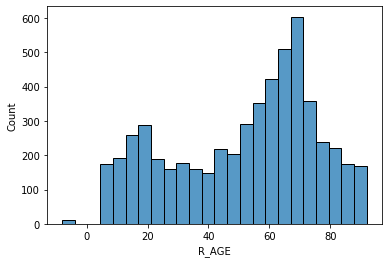

In [10]:
missing = ny_check[ny_check['WHYTRP90']==0]
sns.histplot(missing['R_AGE'])

### Goal is to create a predictive model to help predict and impute missing person trips in order to evaluate Household level trips 

## 1. Merging of Data

### 1.1. Household

In [11]:
#filtering NY Households
ny = household[household['HHSTATE'] == "NY"]

# as only studying hh with car will also filter out hh with HHVEHCNT == 0
ny = ny[ny['HHVEHCNT']>0]

In [12]:
# selection of columns based on prior background inference of potential features
ny = ny[['HOUSEID','HH_CBSA','HOMEOWN','HHSIZE','HHVEHCNT','HHFAMINC','NUMADLT','YOUNGCHILD','WRKCOUNT','MSACAT','MSASIZE','URBAN','URBANSIZE','URBRUR','LIF_CYC']]

### 1.2 Trips

In [13]:
ny_trip = trip[trip['HOUSEID'].isin(ny['HOUSEID'])]

* get most frequent distance bins for each WHYREASON 

In [14]:
trips_data = ny_trip[['HOUSEID','PERSONID','WHYTRP90','TRPMILES']]
trips_data['WHYTRP90'].value_counts()

# top why trips are [3,10,4,1,,8,5]

10    25627
3     23806
4     19880
1     18001
5      8440
8      8325
11     4385
6      3164
2      1954
99       34
Name: WHYTRP90, dtype: int64

In [15]:
trips_data =trips_data[trips_data['WHYTRP90'].isin([1,10,4,3,8,5])]

                counts  percentage
(0.0, 2.0]       26629   25.585373
(-9.001, 0.0]    21629   20.781330
(4.0, 10.0]      20679   19.868561
(10.0, 3621.0]   20273   19.478473
(2.0, 4.0]       14869   14.286263


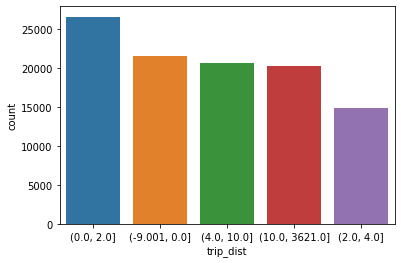

In [16]:
trips_data['round_dist']= trips_data['TRPMILES'].apply(lambda x: math.floor(x))
trips_data['trip_dist'] = pd.qcut(trips_data['round_dist'],5)
cat_col_prop(trips_data,'trip_dist')

In [17]:
# Summarise to Person trip counts 
ny_trip_count = ny_trip[['HOUSEID','PERSONID','TRAVDAY']].groupby(['HOUSEID','PERSONID']).agg('count').reset_index().rename(columns = {'TRAVDAY':'n_trips'})

In [18]:
ny_trip_count.head()

,HOUSEID,PERSONID,n_trips
0,30000012,1,9
1,30000082,1,5
2,30000082,2,7
3,30000130,1,4
4,30000380,1,6


In [19]:
trip_summary = trips_data[['HOUSEID','PERSONID','WHYTRP90','trip_dist']].groupby(['HOUSEID','PERSONID','WHYTRP90'])['trip_dist'].apply(pd.Series.mode).reset_index()
trip_summary['max_dist'] = trip_summary['trip_dist'].apply(lambda x: x.right)

In [20]:
trip_summary = trip_summary[trip_summary.groupby(['HOUSEID','PERSONID','WHYTRP90'])['max_dist'].transform(max) == trip_summary['max_dist']]

trip_summary = trip_summary[['HOUSEID','PERSONID','WHYTRP90','trip_dist']]


In [21]:
pivoted = trip_summary.pivot(index = ['HOUSEID','PERSONID'],
                  columns = 'WHYTRP90',
                  values = 'trip_dist')

trip_why_common = pd.DataFrame(pivoted.to_records()).rename(columns = {'1':'dist_to_work',
                                                       '3':'dist_to_shopping',
                                                        '4':'dist_to_family',
                                                       '5':'dist_to_school_or_church',
                                                        '8': 'dist_to_relatives',
                                                        '10':'dist_to_social'})


* Get the Count of Car Trips

In [22]:
# selecting trips that were done using either 3.Car, 4.SUV, 5.Van
ny_trip = ny_trip[ny_trip['TRPTRANS'].isin([3,4,5])]

In [23]:
print(str(sum(ny_trip['TRVLCMIN']<=0)), ' trips missing TRVLCMIN info so will just remove since only ',str(sum(ny_trip['TRVLCMIN']<=0)/len(ny_trip)*100),"%")
ny_trip = ny_trip[ny_trip['TRVLCMIN']>0]

84  trips missing TRVLCMIN info so will just remove since only  0.09621221666074885 %


In [24]:
# since only 24 lines with trip distance <= 0, removed lines
print('# of trips with dist <=0,', str(sum(ny_trip['TRPMILES']<=0)),' out of', str(len(ny_trip)))
ny_trip = ny_trip[ny_trip['TRPMILES']>0]

# of trips with dist <=0, 22  out of 87223


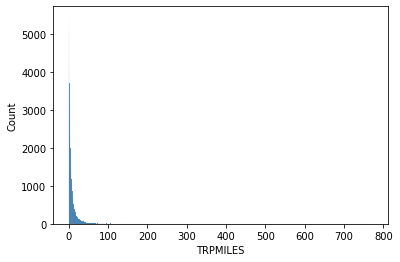

In [25]:
#Remove outlier trip miles
sns.histplot(ny_trip['TRPMILES'])
#ny_trip = ny_trip[ny_trip['TRPMILES']<40]
ny_trip = ny_trip[ny_trip['TRPMILES']<100]

In [26]:
ny_trip_count = ny_trip_count.merge(trip_why_common, how = 'left',left_on = ['HOUSEID','PERSONID'],right_on = ['HOUSEID','PERSONID'])

## 1.3 People

In [27]:
# filtering people from New York
nyorker = person[person['HOUSEID'].isin(ny['HOUSEID'])]

In [28]:
# selection of columns based on prior background inference of potential features
nyorker = nyorker[['HOUSEID','PERSONID','R_AGE','EDUC','R_RACE','R_SEX','WRK_HOME','WKFTPT','OCCAT','DRIVER','TRAVDAY','DISTTOWK17','DISTTOSC17','OUTOFTWN']]


In [29]:
# Remove those out of town
nyorker = nyorker[nyorker['OUTOFTWN']==2]
nyorker.drop(['OUTOFTWN'],axis =1, inplace = True)

In [30]:
ny_trip_count

,HOUSEID,PERSONID,n_trips,dist_to_work,dist_to_shopping,dist_to_family,dist_to_school_or_church,dist_to_relatives,dist_to_social
0,30000012,1,9,"(4.0, 10.0]",NaN,NaN,NaN,"(10.0, 3621.0]","(2.0, 4.0]"
1,30000082,1,5,"(0.0, 2.0]",NaN,"(0.0, 2.0]",NaN,NaN,"(0.0, 2.0]"
2,30000082,2,7,NaN,"(0.0, 2.0]",NaN,NaN,NaN,"(10.0, 3621.0]"
3,30000130,1,4,"(10.0, 3621.0]",NaN,NaN,NaN,NaN,NaN
4,30000380,1,6,NaN,"(0.0, 2.0]",NaN,NaN,NaN,"(-9.001, 0.0]"
...,...,...,...,...,...,...,...,...,...
26765,40793808,2,9,NaN,"(0.0, 2.0]","(4.0, 10.0]",NaN,NaN,"(0.0, 2.0]"
26766,40793808,3,5,NaN,"(4.0, 10.0]",NaN,NaN,NaN,"(-9.001, 0.0]"
26767,40793974,1,7,NaN,"(4.0, 10.0]",NaN,NaN,"(4.0, 10.0]","(2.0, 4.0]"
26768,40794020,1,6,NaN,"(4.0, 10.0]","(-9.001, 0.0]",NaN,NaN,NaN


In [31]:
# merging of Person, Household and Trips to Person
df= nyorker.merge(ny_trip_count, how = 'left', left_on = ['HOUSEID','PERSONID'],right_on = ['HOUSEID','PERSONID'])
df = df.merge(ny, how = 'left', left_on = 'HOUSEID', right_on = 'HOUSEID')

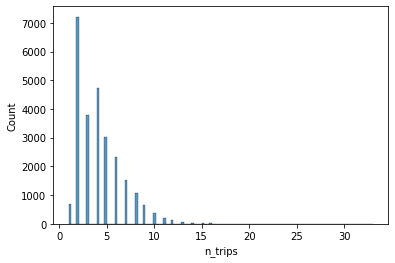

In [32]:
# Replace NA trip counts with 0
sns.histplot(df['n_trips'])
df['n_trips'][df['n_trips'].isna()] = 0
#df = df[df['n_trips']>0]
df = df[df['n_trips']<10]

In [33]:
[c for c in df]

['HOUSEID',
 'PERSONID',
 'R_AGE',
 'EDUC',
 'R_RACE',
 'R_SEX',
 'WRK_HOME',
 'WKFTPT',
 'OCCAT',
 'DRIVER',
 'TRAVDAY',
 'DISTTOWK17',
 'DISTTOSC17',
 'n_trips',
 'dist_to_work',
 'dist_to_shopping',
 'dist_to_family',
 'dist_to_school_or_church',
 'dist_to_relatives',
 'dist_to_social',
 'HH_CBSA',
 'HOMEOWN',
 'HHSIZE',
 'HHVEHCNT',
 'HHFAMINC',
 'NUMADLT',
 'YOUNGCHILD',
 'WRKCOUNT',
 'MSACAT',
 'MSASIZE',
 'URBAN',
 'URBANSIZE',
 'URBRUR',
 'LIF_CYC']

In [34]:
df.shape

(30150, 34)

## Reason for Model

In [35]:
ny_trip_count

,HOUSEID,PERSONID,n_trips,dist_to_work,dist_to_shopping,dist_to_family,dist_to_school_or_church,dist_to_relatives,dist_to_social
0,30000012,1,9,"(4.0, 10.0]",NaN,NaN,NaN,"(10.0, 3621.0]","(2.0, 4.0]"
1,30000082,1,5,"(0.0, 2.0]",NaN,"(0.0, 2.0]",NaN,NaN,"(0.0, 2.0]"
2,30000082,2,7,NaN,"(0.0, 2.0]",NaN,NaN,NaN,"(10.0, 3621.0]"
3,30000130,1,4,"(10.0, 3621.0]",NaN,NaN,NaN,NaN,NaN
4,30000380,1,6,NaN,"(0.0, 2.0]",NaN,NaN,NaN,"(-9.001, 0.0]"
...,...,...,...,...,...,...,...,...,...
26765,40793808,2,9,NaN,"(0.0, 2.0]","(4.0, 10.0]",NaN,NaN,"(0.0, 2.0]"
26766,40793808,3,5,NaN,"(4.0, 10.0]",NaN,NaN,NaN,"(-9.001, 0.0]"
26767,40793974,1,7,NaN,"(4.0, 10.0]",NaN,NaN,"(4.0, 10.0]","(2.0, 4.0]"
26768,40794020,1,6,NaN,"(4.0, 10.0]","(-9.001, 0.0]",NaN,NaN,NaN


In [36]:
ny_trip_check = ny_trip[['HOUSEID','PERSONID','WHYTRP90']].groupby(['HOUSEID','PERSONID']).count().reset_index()
ny_check = nyorker.merge(ny_trip_check, how = 'left', left_on=['HOUSEID','PERSONID'],right_on=['HOUSEID','PERSONID'])

In [37]:
ny_check['WHYTRP90'][ny_check['WHYTRP90']>0] =1
ny_check['WHYTRP90'][ny_check['WHYTRP90'].isna()] =0

In [38]:
hh_rate = ny_check.groupby(['HOUSEID']).agg({'HOUSEID':'count',
                                  'WHYTRP90':'sum'})

hh_hitrate = sum(hh_rate['WHYTRP90']==0)/hh_rate.shape[0]*100

print('of ',str(hh_rate.shape[0]),' households, ',str(hh_hitrate), '% did not provide any trip info')

of  15230  households,  18.01050558108995 % did not provide any trip info


In [39]:
person_hitrate = sum(ny_check['WHYTRP90']==0)/ny_check.shape[0]*100

print('of', str(ny_check.shape[0]),' person info,',str(person_hitrate),'% did not provide any trip info')


of 31051  person info, 30.8428069949438 % did not provide any trip info


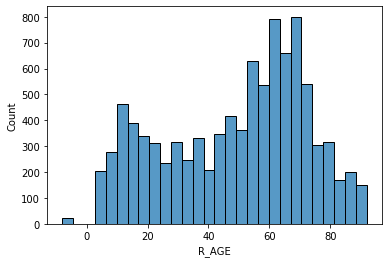

In [40]:
sns.histplot(ny_check['R_AGE'][ny_check['WHYTRP90']==0])

# not only those too young missing

### Therefore to create predictive model to help 'fill up' missing trip info to provide household level trip estimates. 

other reccommendation: for future survey can get volunteer to provide some of the key features of family members (e.g. dist to workplace or school) to help provide estimate of houshold total trips

## 2. EDA & Feature Engineering 

### 2.1. Train, Test, Split

In [41]:
x_col = [c for c in df if c not in ["HOUSEID","PERSONID","n_trips"]]
x_df = df[x_col]
y_df = df['n_trips']

x_train , x_test, y_train, y_test = model_selection.train_test_split(x_df, y_df, test_size = 0.2, random_state = 888)

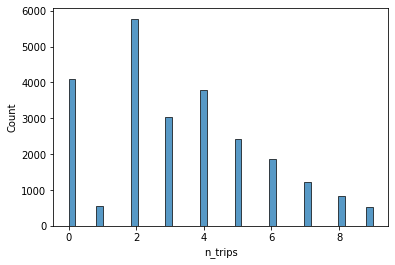

In [42]:
sns.histplot(y_train)

In [43]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24120 entries, 8781 to 11121
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype            
---  ------                    --------------  -----            
 0   R_AGE                     24120 non-null  int64            
 1   EDUC                      24120 non-null  int64            
 2   R_RACE                    24120 non-null  int64            
 3   R_SEX                     24120 non-null  int64            
 4   WRK_HOME                  24120 non-null  int64            
 5   WKFTPT                    24120 non-null  int64            
 6   OCCAT                     24120 non-null  int64            
 7   DRIVER                    24120 non-null  int64            
 8   TRAVDAY                   24120 non-null  int64            
 9   DISTTOWK17                24120 non-null  float64          
 10  DISTTOSC17                24120 non-null  float64          
 11  dist_to_work              6726 non-nul

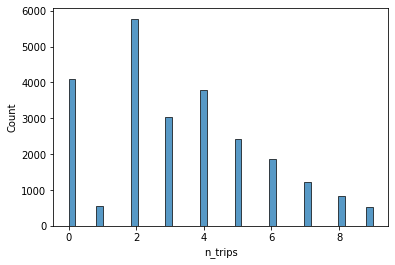

In [44]:
sns.histplot(y_train)

### 2.2. Feature Engineering

#### Age (R_AGE)

59 count of people with no age.  0.0002762702755890612 %.


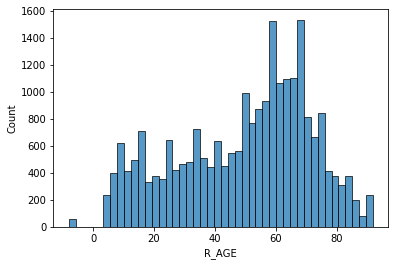

In [45]:
print(str(sum(x_train['R_AGE']<0)), "count of people with no age. ",str(sum(nyorker['R_AGE']<0)/person.shape[0]),"%.")

sns.histplot(x_train['R_AGE'])

# impute missing values (<0) with mean age
mean_age = round(x_train['R_AGE'][x_train['R_AGE']>0].mean())
x_train['R_AGE'][x_train['R_AGE']<0] = mean_age
x_test['R_AGE'][x_test['R_AGE']<0] = mean_age

In [46]:
x_train['AGE_bins']= 'NA'
x_train.loc[x_train['R_AGE'].between(5,15,inclusive = True), 'AGE_bins'] = "5_to_15"
x_train.loc[x_train['R_AGE'].between(16,25,inclusive = True), 'AGE_bins'] = "16_to_25"
x_train.loc[x_train['R_AGE'].between(26,35,inclusive = True), 'AGE_bins'] = "26_to_35"
x_train.loc[x_train['R_AGE'].between(36,45,inclusive = True), 'AGE_bins'] = "36_to_45"
x_train.loc[x_train['R_AGE'].between(46,55,inclusive = True), 'AGE_bins'] = "46_to_55"
x_train.loc[x_train['R_AGE'].between(56,65,inclusive = True), 'AGE_bins'] = "56_to_65"
x_train.loc[x_train['R_AGE'].between(66,75,inclusive = True), 'AGE_bins'] = "66_to_75"
x_train.loc[x_train['R_AGE']>75, 'AGE_bins'] = "more_than_75"

x_test['AGE_bins']= 'NA'
x_test.loc[x_test['R_AGE'].between(5,15,inclusive = True), 'AGE_bins'] = "5_to_15"
x_test.loc[x_test['R_AGE'].between(16,25,inclusive = True), 'AGE_bins'] = "16_to_25"
x_test.loc[x_test['R_AGE'].between(26,35,inclusive = True), 'AGE_bins'] = "26_to_35"
x_test.loc[x_test['R_AGE'].between(36,45,inclusive = True), 'AGE_bins'] = "36_to_45"
x_test.loc[x_test['R_AGE'].between(46,55,inclusive = True), 'AGE_bins'] = "46_to_55"
x_test.loc[x_test['R_AGE'].between(56,65,inclusive = True), 'AGE_bins'] = "56_to_65"
x_test.loc[x_test['R_AGE'].between(66,75,inclusive = True), 'AGE_bins'] = "66_to_75"
x_test.loc[x_test['R_AGE']>75, 'AGE_bins'] = "more_than_75"


              counts  percentage
56_to_65        5199   21.554726
66_to_75        4137   17.151741
46_to_55        3542   14.684909
5_to_15         2414   10.008292
26_to_35        2328    9.651741
36_to_45        2313    9.589552
more_than_75    2237    9.274461
16_to_25        1950    8.084577


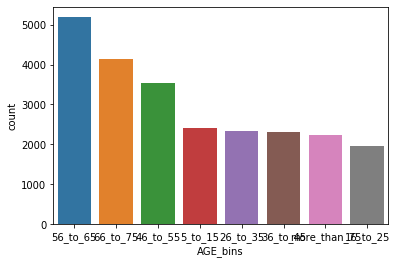

In [47]:
cat_col_prop(x_train,'AGE_bins')

#### Educational Attainment (EDUC)

    counts  percentage
 3    5970   24.751244
 5    5211   21.604478
 2    4764   19.751244
 4    4610   19.112769
-1    1928    7.993367
 1    1622    6.724710
-7       9    0.037313
-8       6    0.024876


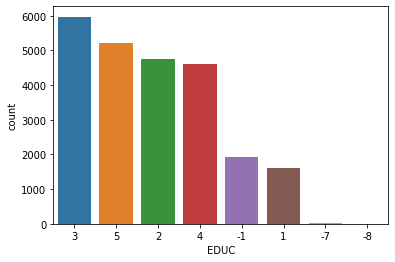

In [48]:
cat_col_prop(x_train,'EDUC')
# approx 8% missing values (<0). To take note of but will addresss in one-hot encoding

#### Race (R_RACE)

     counts  percentage
 1    21536   89.286899
 3      787    3.262852
 2      770    3.192371
 6      518    2.147595
 97     308    1.276949
-7      116    0.480929
 4       55    0.228027
 5       18    0.074627
-8       12    0.049751


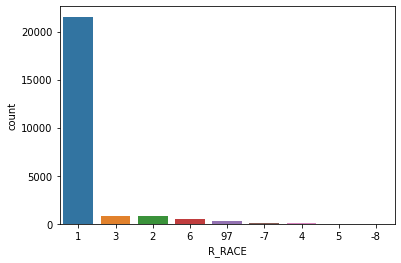

In [49]:
cat_col_prop(x_train,'R_RACE')
# approx 1% missing values (<0). To take note of but will address in one-hot encoding
# Significant proportion of members 'white'

#### Gender (R_SEX)

    counts  percentage
 2   12603   52.251244
 1   11496   47.661692
-7      17    0.070481
-8       4    0.016584


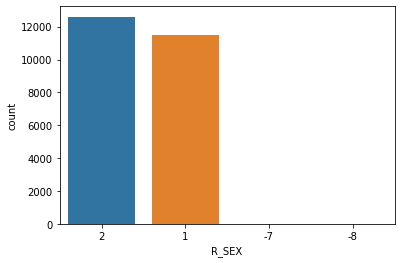

In [50]:
cat_col_prop(x_train, 'R_SEX')
# <1% missing values. To take note but will be addressed in one-hot encoding

#### Work From Home (WRK_HOME)

    counts  percentage
-1   12108   50.199005
 2   10277   42.607794
 1    1282    5.315091
-9     452    1.873964
-7       1    0.004146


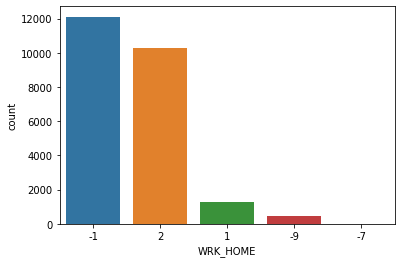

In [51]:
cat_col_prop(x_train,'WRK_HOME')
# Significant proportion -1 (50%) which is the appropriate skip (due to not working) - to address in one-hot

#### Work - Part Time or Full Time (WKFTPT)

    counts  percentage
-1   12560   52.072968
 1    8975   37.209784
 2    2581   10.700663
-7       3    0.012438
-8       1    0.004146


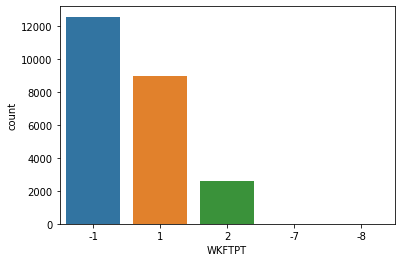

In [52]:
cat_col_prop(x_train,'WKFTPT')
# Significant proportion -1 (52%) which is the appropriate skip (due to not working) - to address in one-hot

#### Job Category (OCCAT)

     counts  percentage
-1    12108   50.199005
 4     6329   26.239635
 1     2432   10.082919
 3     1423    5.899668
 2     1354    5.613599
-9      452    1.873964
 97      15    0.062189
-8        5    0.020730
-7        2    0.008292


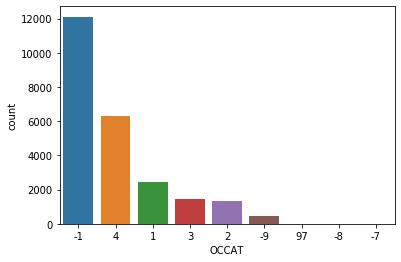

In [53]:
cat_col_prop(x_train,'OCCAT')
# Significant proportion -1 (50%) which is the appropriate skip (due to not working) - to address in one-hot

#### Driver Status (DRIVER)

    counts  percentage
 1   20240   83.913765
-1    2181    9.042289
 2    1699    7.043947


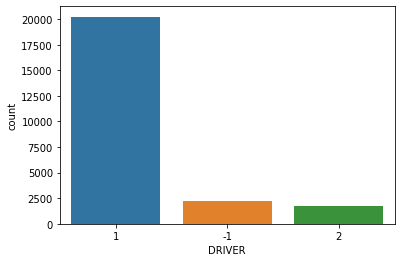

In [54]:
cat_col_prop(x_train,'DRIVER')

#Significant proportion -1 (8.7%) (due to too young) - to address in one-hot encoding
#sns.boxplot(data = x_train, x='DRIVER',y='AGE_bins')

#### Distance to Work

In [55]:
#To Bin Non zeros
#sns.histplot(x_train['DISTTOWK17'])
pd.qcut(x_train['DISTTOWK17'][x_train['DISTTOWK17']>0],5)

7436                   (6.89, 12.302]
26206                    (3.12, 6.89]
12559                  (6.89, 12.302]
17206                    (3.12, 6.89]
18789    (0.009000000000000001, 3.12]
                     ...             
19447                    (3.12, 6.89]
25328                    (3.12, 6.89]
17769                    (3.12, 6.89]
5456                   (6.89, 12.302]
15324    (0.009000000000000001, 3.12]
Name: DISTTOWK17, Length: 10223, dtype: category
Categories (5, interval[float64]): [(0.009000000000000001, 3.12] < (3.12, 6.89] < (6.89, 12.302] < (12.302, 22.27] < (22.27, 2919.7]]

                   counts  percentage
NA                  13897   57.616086
DISTTOWK_3_to_7      2180    9.038143
DISTTOWK_12_to_22    2093    8.677446
DISTTOWK_above_22    2088    8.656716
DISTTOWK_0_to_3      1962    8.134328
DISTTOWK_7_to_12     1900    7.877280


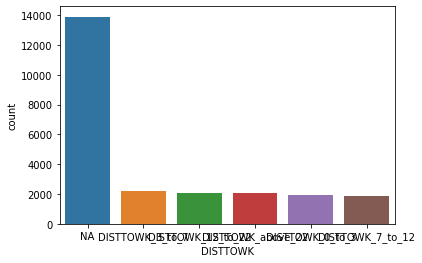

In [56]:
x_train['DISTTOWK'] = 'NA'
x_train.loc[x_train['DISTTOWK17']==0, 'DISTTOWK'] = 'NA'
x_train.loc[x_train['DISTTOWK17']==-9, 'DISTTOWK'] = 'NA'
x_train.loc[x_train['DISTTOWK17'].between(.009000000000000000,3,inclusive = True),'DISTTOWK'] = 'DISTTOWK_0_to_3'
x_train.loc[x_train['DISTTOWK17'].between(3,7, inclusive = True),'DISTTOWK'] = 'DISTTOWK_3_to_7'
x_train.loc[x_train['DISTTOWK17'].between(7,12, inclusive = True),'DISTTOWK'] = 'DISTTOWK_7_to_12'
x_train.loc[x_train['DISTTOWK17'].between(12,22, inclusive = True),'DISTTOWK'] = 'DISTTOWK_12_to_22'
x_train.loc[x_train['DISTTOWK17']>22,'DISTTOWK'] = 'DISTTOWK_above_22'
cat_col_prop(x_train,'DISTTOWK')
x_train.drop(['DISTTOWK17'],axis=1, inplace = True)

x_test['DISTTOWK'] = 'NA'
x_test.loc[x_test['DISTTOWK17']==0, 'DISTTOWK'] = 'NA'
x_test.loc[x_test['DISTTOWK17']==-9, 'DISTTOWK'] = 'NA'
x_test.loc[x_test['DISTTOWK17'].between(.009000000000000000,3,inclusive = True),'DISTTOWK'] = 'DISTTOWK_0_to_3'
x_test.loc[x_test['DISTTOWK17'].between(3,7, inclusive = True),'DISTTOWK'] = 'DISTTOWK_3_to_7'
x_test.loc[x_test['DISTTOWK17'].between(7,12, inclusive = True),'DISTTOWK'] = 'DISTTOWK_7_to_12'
x_test.loc[x_test['DISTTOWK17'].between(12,22, inclusive = True),'DISTTOWK'] = 'DISTTOWK_12_to_22'
x_test.loc[x_test['DISTTOWK17']>22,'DISTTOWK'] = 'DISTTOWK_above_22'
x_test.drop(['DISTTOWK17'],axis=1, inplace = True)

#### Distance to School

In [57]:
pd.qcut(x_train['DISTTOSC17'][x_train['DISTTOSC17']>0],2)

7420     (0.009000000000000001, 2.81]
7678     (0.009000000000000001, 2.81]
6543                  (2.81, 2784.08]
30559                 (2.81, 2784.08]
20075    (0.009000000000000001, 2.81]
                     ...             
673      (0.009000000000000001, 2.81]
5423     (0.009000000000000001, 2.81]
17111    (0.009000000000000001, 2.81]
23385    (0.009000000000000001, 2.81]
11121                 (2.81, 2784.08]
Name: DISTTOSC17, Length: 2729, dtype: category
Categories (2, interval[float64]): [(0.009000000000000001, 2.81] < (2.81, 2784.08]]

                  counts  percentage
NA                 21391   88.685738
DISTTOSC_under_3    1428    5.920398
DISTTOSC_above_3    1301    5.393864


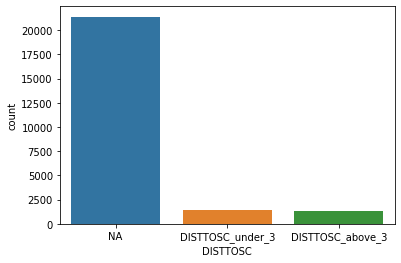

In [58]:
x_train['DISTTOSC'] = 'NA'
x_train.loc[x_train['DISTTOSC17']<=0, 'DISTTOSC'] = 'NA'
x_train.loc[x_train['DISTTOSC17'].between(.008,3,inclusive = True),'DISTTOSC'] = 'DISTTOSC_under_3'
x_train.loc[x_train['DISTTOSC17']>3,'DISTTOSC'] = 'DISTTOSC_above_3'
cat_col_prop(x_train,'DISTTOSC')
x_train.drop(['DISTTOSC17'],axis=1, inplace = True)


x_test['DISTTOSC'] = 'NA'
x_test.loc[x_test['DISTTOSC17']<=0, 'DISTTOSC'] = 'NA'
x_test.loc[x_test['DISTTOSC17'].between(.008,3,inclusive = True),'DISTTOSC'] = 'DISTTOSC_under_3'
x_test.loc[x_test['DISTTOSC17']>3,'DISTTOSC'] = 'DISTTOSC_above_3'
x_test.drop(['DISTTOSC17'],axis=1, inplace = True)

#### Travel Day (TRAVDAY)

   counts  percentage
1    3620   15.008292
2    3548   14.709784
7    3460   14.344942
6    3427   14.208126
5    3408   14.129353
3    3355   13.909619
4    3302   13.689884


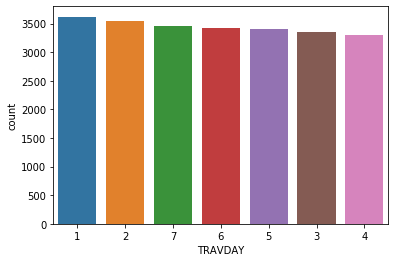

In [59]:
cat_col_prop(x_train,'TRAVDAY')

#### Core Based Statiscal Area FIPS code (HH_CBSA)

       counts  percentage
XXXXX   14272   59.170813
35620    7306   30.290216
40380    1365    5.659204
15380    1177    4.879768


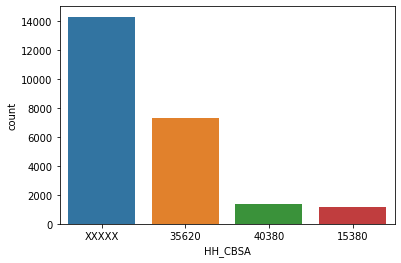

In [60]:
#Core Based Statistical Area (CBSA) FIPS code for the respondent's home address

cat_col_prop(x_train,'HH_CBSA')

# significant number of households under the 'XXXXX=Suppressed, in an MSA of less than 1 million ' category

####  Home Ownership (HOMEOWN)

     counts  percentage
 1    20319   84.241294
 2     3622   15.016584
 97     176    0.729685
-7        3    0.012438


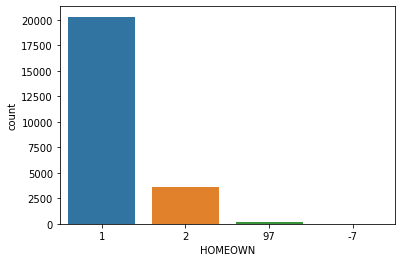

In [61]:
cat_col_prop(x_train,'HOMEOWN')
#Small count with missing value 2. to address in one-hot encoding

#### Household Vehicle Count (HHVEHCNT)

    counts  percentage
2    10752   44.577114
1     6353   26.339138
3     4362   18.084577
4     1699    7.043947
5      617    2.558043
6      221    0.916252
7       77    0.319237
8       21    0.087065
11      11    0.045605
9        5    0.020730
12       2    0.008292
________
new HHVEHCNT
    counts  percentage
2    10752   44.577114
1     6353   26.339138
3     4362   18.084577
>3    2653   10.999171


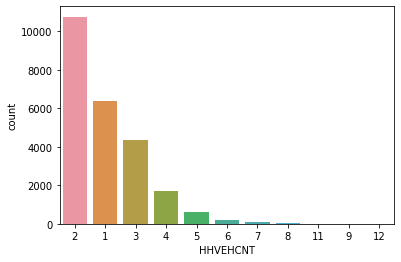

In [62]:
#count of household vehicles

cat_col_prop(x_train,'HHVEHCNT')

# as group size significantly smaller from 4 and above to bin to a single group

x_train['HHVEHCNT'][x_train['HHVEHCNT']>3] = ">3"
x_test['HHVEHCNT'][x_test['HHVEHCNT']>3] = ">3"

print("________")
print("new HHVEHCNT")
print(pd.concat([x_train['HHVEHCNT'].value_counts(),
          x_train['HHVEHCNT'].value_counts(normalize = True).mul(100)],axis = 1, keys = ('counts','percentage'))
    )

#### Family Income (HHFAMINC)

     counts  percentage
 6     4299   17.823383
 7     3605   14.946103
 8     2962   12.280265
 5     2608   10.812604
 4     1859    7.707297
 9     1764    7.313433
 11    1704    7.064677
 10    1676    6.948590
 3     1561    6.471808
 2      746    3.092869
-7      714    2.960199
 1      516    2.139303
-8      104    0.431177
-9        2    0.008292


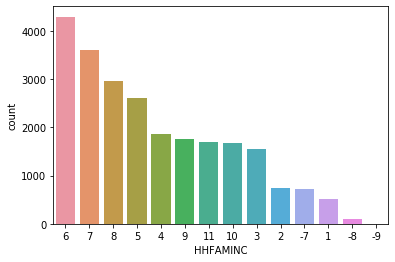

In [63]:
cat_col_prop(x_train,'HHFAMINC')
# approx 3% missing (<0) to address in one-hot encoding

#### Adult Ratio  (NUMADLT)

    counts  percentage
2    15351   63.644279
1     4041   16.753731
3     3270   13.557214
4     1137    4.713930
5      258    1.069652
6       36    0.149254
7       13    0.053897
10       8    0.033167
8        6    0.024876


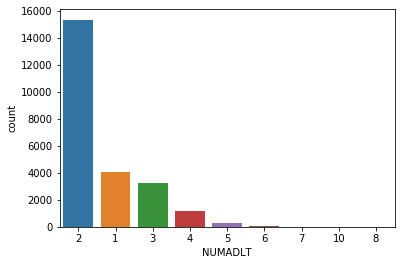

In [64]:
cat_col_prop(x_train, 'NUMADLT')
#no missing values

Before
          counts  percentage
1.000000   16710   69.278607
0.500000    2674   11.086235
0.666667    1829    7.582919
0.400000     835    3.461857
0.750000     629    2.607794
0.333333     496    2.056385
0.600000     329    1.364013
0.800000     194    0.804312
0.250000      84    0.348259
0.285714      78    0.323383
0.714286      43    0.178275
0.428571      42    0.174129
0.833333      39    0.161692
0.571429      33    0.136816
0.375000      19    0.078773
0.200000      15    0.062189
0.222222      14    0.058043
0.444444      12    0.049751
0.625000      11    0.045605
0.166667      10    0.041459
0.700000       7    0.029022
0.857143       6    0.024876
0.142857       6    0.024876
0.363636       5    0.020730

After
               counts  percentage
1               16710   69.278607
more_than_0.5    5794   24.021559
less_than_0.5    1616    6.699834


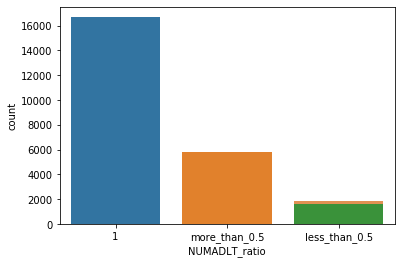

In [65]:
#Convert against proportion of Household size
x_train['NUMADLT'] = x_train['NUMADLT']/x_train['HHSIZE']
x_test['NUMADLT'] = x_test['NUMADLT']/x_test['HHSIZE']
print('Before')
cat_col_prop(x_train,'NUMADLT')
#significant number of varying factors
#to bin into groups
x_train['NUMADLT_ratio'] = 'NA'
x_train.loc[x_train['NUMADLT']==0, 'NUMADLT_ratio'] = '0'
x_train.loc[x_train['NUMADLT'].between(0,0.5,inclusive = False),'NUMADLT_ratio'] = 'less_than_0.5'
x_train.loc[x_train['NUMADLT'].between(0.5,1, inclusive = True),'NUMADLT_ratio'] = 'more_than_0.5'
x_train.loc[x_train['NUMADLT']==1,'NUMADLT_ratio'] ='1'
print('')
print('After')
cat_col_prop(x_train,'NUMADLT_ratio')


x_test['NUMADLT_ratio'] = 'NA'
x_test.loc[x_test['NUMADLT']==0, 'NUMADLT_ratio'] = '0'
x_test.loc[x_test['NUMADLT'].between(0,0.5,inclusive = False),'NUMADLT_ratio'] = 'less_than_0.5'
x_test.loc[x_test['NUMADLT'].between(0.5,1, inclusive = True),'NUMADLT_ratio'] = 'more_than_0.5'
x_test.loc[x_test['NUMADLT']==1,'NUMADLT_ratio'] ='1'

#### Young Child Ratio (YOUNGCHILD)

   counts  percentage
0   21994   91.185738
1    1579    6.546434
2     496    2.056385
3      44    0.182421
5       5    0.020730
4       2    0.008292


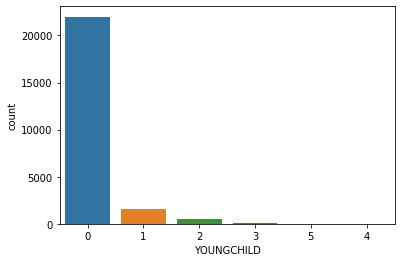

In [66]:
cat_col_prop(x_train,'YOUNGCHILD')

               counts  percentage
0               21994   91.185738
less_than_0.5    1825    7.566335
more_than_0.5     301    1.247927


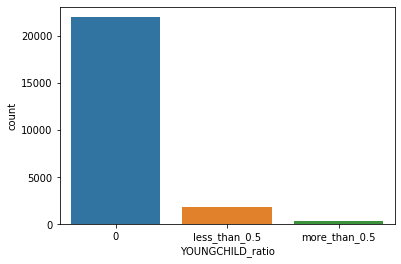

In [67]:
#Convert against proportion of Household size

x_train['YOUNGCHILD'] = x_train['YOUNGCHILD']/x_train['HHSIZE']
x_test['YOUNGCHILD'] = x_test['YOUNGCHILD']/x_test['HHSIZE']

#Bin to groups
x_train['YOUNGCHILD_ratio'] = 'NA'
x_train.loc[x_train['YOUNGCHILD']==0,'YOUNGCHILD_ratio']= '0'
x_train.loc[x_train['YOUNGCHILD'].between(0,0.5,inclusive = False),'YOUNGCHILD_ratio'] = 'less_than_0.5'
x_train.loc[x_train['YOUNGCHILD'].between(0.5,1, inclusive = True),'YOUNGCHILD_ratio'] = 'more_than_0.5'
x_train.loc[x_train['YOUNGCHILD']==1,'YOUNGCHILD_ratio'] ='1'
 

cat_col_prop(x_train,'YOUNGCHILD_ratio')    

x_test['YOUNGCHILD_ratio'] = 'NA'
x_test.loc[x_test['YOUNGCHILD']==0,'YOUNGCHILD_ratio']= '0'
x_test.loc[x_test['YOUNGCHILD'].between(0,0.5,inclusive = False),'YOUNGCHILD_ratio'] = 'less_than_0.5'
x_test.loc[x_test['YOUNGCHILD'].between(0.5,1, inclusive = True),'YOUNGCHILD_ratio'] = 'more_than_0.5'
x_test.loc[x_test['YOUNGCHILD']==1,'YOUNGCHILD_ratio'] ='1'
 


#### Worker Count Proportion (WRKCOUNT)

   counts  percentage
2    8295   34.390547
1    7378   30.588723
0    6333   26.256219
3    1574    6.525705
4     481    1.994196
5      47    0.194859
6       6    0.024876
7       6    0.024876


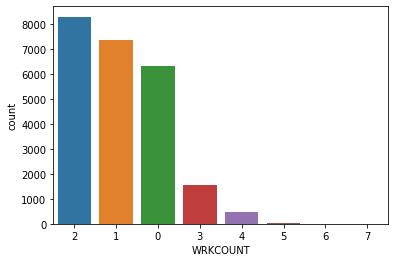

In [68]:
cat_col_prop(x_train,'WRKCOUNT')

               counts  percentage
more_than_0.5    7994   33.142620
0                6333   26.256219
1                6006   24.900498
less_than_0.5    3787   15.700663


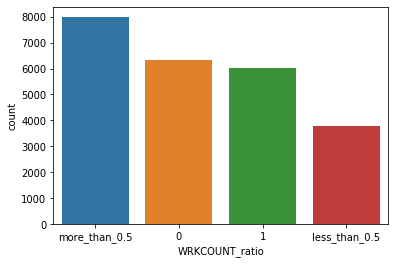

In [69]:
#Convert against proportion of Household size

x_train['WRKCOUNT'] = x_train['WRKCOUNT']/x_train['HHSIZE']
x_test['WRKCOUNT'] = x_test['WRKCOUNT']/x_test['HHSIZE']

#Bin to groups
x_train['WRKCOUNT_ratio'] = 'NA'
x_train.loc[x_train['WRKCOUNT']==0,'WRKCOUNT_ratio']= '0'
x_train.loc[x_train['WRKCOUNT'].between(0,0.5,inclusive = False),'WRKCOUNT_ratio'] = 'less_than_0.5'
x_train.loc[x_train['WRKCOUNT'].between(0.5,1, inclusive = True),'WRKCOUNT_ratio'] = 'more_than_0.5'
x_train.loc[x_train['WRKCOUNT']==1,'WRKCOUNT_ratio'] ='1'

cat_col_prop(x_train,'WRKCOUNT_ratio')

x_test['WRKCOUNT_ratio'] = 'NA'
x_test.loc[x_test['WRKCOUNT']==0,'WRKCOUNT_ratio']= '0'
x_test.loc[x_test['WRKCOUNT'].between(0,0.5,inclusive = False),'WRKCOUNT_ratio'] = 'less_than_0.5'
x_test.loc[x_test['WRKCOUNT'].between(0.5,1, inclusive = True),'WRKCOUNT_ratio'] = 'more_than_0.5'
x_test.loc[x_test['WRKCOUNT']==1,'WRKCOUNT_ratio'] ='1'

 

#### Household Size (HHSIZE)

Before
    counts  percentage
2    10322   42.794362
3     4130   17.122720
4     3794   15.729685
1     3482   14.436153
5     1526    6.326700
6      497    2.060531
7      214    0.887231
8       83    0.344113
9       40    0.165837
10      27    0.111940
11       5    0.020730

After
         counts  percentage
2         10322   42.794362
above_3    6186   25.646766
3          4130   17.122720
1          3482   14.436153


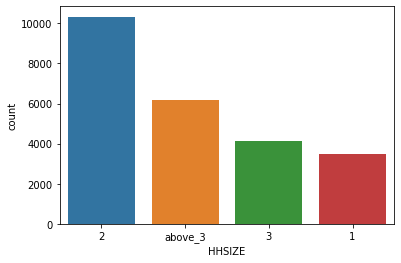

In [70]:
#count of household members
print("Before")
cat_col_prop(x_train,'HHSIZE')

# to bin tail HHSIZE

x_train['HHSIZE'][x_train['HHSIZE']>3] = "above_3"

print("")
print("After")

cat_col_prop(x_train,'HHSIZE')

x_test['HHSIZE'][x_test['HHSIZE']>3] = " above_3"

#### Metropolitan Statistical Area (MSACAT)


   counts  percentage
3   10347   42.898010
1    7306   30.290216
4    3925   16.272803
2    2542   10.538972


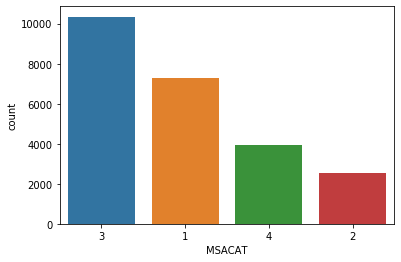

In [71]:
cat_col_prop(x_train,'MSACAT')
             
#no missing values and relatively proportional distribution

#### Population size of MSA (MSASIZE)

   counts  percentage
5    7306   30.290216
1    6038   25.033167
6    3925   16.272803
3    3284   13.615257
4    2542   10.538972
2    1025    4.249585


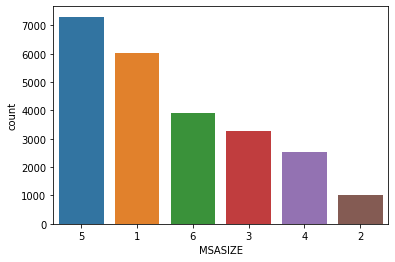

In [72]:
cat_col_prop(x_train,'MSASIZE')
             
#no missing values and relatively proportional distribution

#### House in Urban or Rural Area (URBAN)

Before
   counts  percentage
1   13551   56.181592
4    8248   34.195688
2    2317    9.606136
3       4    0.016584

After
       counts  percentage
urban   15868   65.787728
rural    8252   34.212272


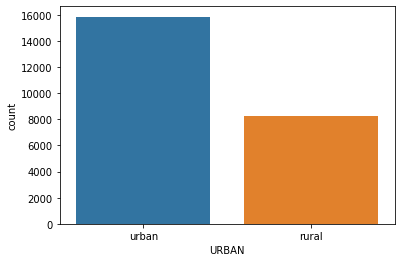

In [73]:
print('Before')
cat_col_prop(x_train,'URBAN')

# combine 1 and 2 (in an urban area and in an urban cluster ) & combine 3 and 4 (surround by urban and not in urban)

x_train['URBAN'][x_train['URBAN'].isin([1,2])] = 'urban'
x_train['URBAN'][x_train['URBAN'].isin([3,4])] = 'rural'

print("")
print('After')

cat_col_prop(x_train, 'URBAN')

x_test['URBAN'][x_test['URBAN'].isin([1,2])] = 'urban'
x_test['URBAN'][x_test['URBAN'].isin([3,4])] = 'rural'

#### URBANSIZE

   counts  percentage
6   10569   43.818408
5    4724   19.585406
1    3653   15.145108
3    2702   11.202322
2    2472   10.248756


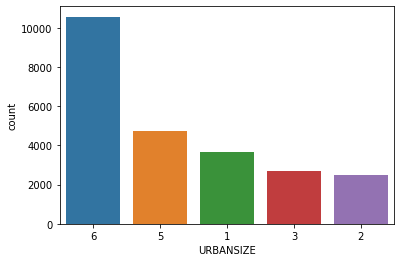

In [74]:
#06 = not in an urbanised area 
#05 - 1 million with heavy rail 

#Relatively proportional classes
cat_col_prop(x_train,'URBANSIZE')

#### URBRUR

   counts  percentage
1   15868   65.787728
2    8252   34.212272


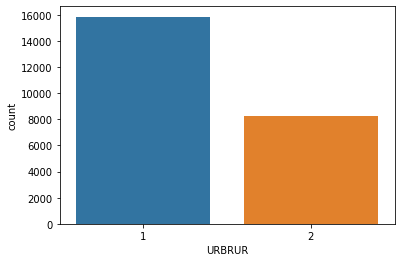

In [75]:
cat_col_prop(x_train,'URBRUR')
# missing values nor disproportion

#### LIF_CYC 

    counts  percentage
10    6699   27.773632
2     5495   22.781924
6     3639   15.087065
4     2435   10.095357
1     1830    7.587065
9     1652    6.849088
8     1572    6.517413
5      457    1.894693
7      200    0.829187
3      141    0.584577


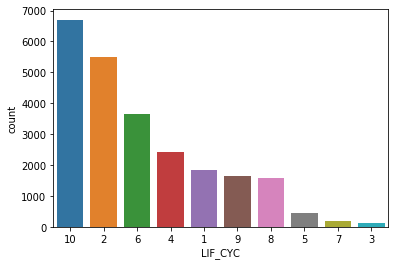

In [76]:
cat_col_prop(x_train,"LIF_CYC")

# No major disproportion

## 3. One-Hot- Encoding

In [77]:
x_train.dtypes

R_AGE                                   int64
EDUC                                    int64
R_RACE                                  int64
R_SEX                                   int64
WRK_HOME                                int64
WKFTPT                                  int64
OCCAT                                   int64
DRIVER                                  int64
TRAVDAY                                 int64
dist_to_work                interval[float64]
dist_to_shopping            interval[float64]
dist_to_family              interval[float64]
dist_to_school_or_church    interval[float64]
dist_to_relatives           interval[float64]
dist_to_social              interval[float64]
HH_CBSA                                object
HOMEOWN                                 int64
HHSIZE                                 object
HHVEHCNT                               object
HHFAMINC                                int64
NUMADLT                               float64
YOUNGCHILD                        

In [78]:
to_obj = ['EDUC','R_RACE','AGE_bins','HHFAMINC','HOMEOWN','R_SEX','TRAVDAY','WRK_HOME','WKFTPT','OCCAT','DRIVER','MSACAT','MSASIZE','URBAN','URBANSIZE','URBRUR','LIF_CYC','dist_to_work','dist_to_shopping','dist_to_family','dist_to_school_or_church','dist_to_relatives','dist_to_social']

x_train[to_obj] = x_train[to_obj].astype(str)
x_test[to_obj]= x_test[to_obj].astype(str)

x_train.drop(['R_AGE'], axis = 1, inplace =True)
x_test.drop(['R_AGE'],axis = 1, inplace = True)

In [79]:
one_hot_col = [c for c in x_train if x_train[c].dtypes == 'O' ]
x_train = pd.concat([x_train,pd.get_dummies(x_train[one_hot_col],prefix = one_hot_col)],axis = 1)
x_train.drop(one_hot_col, axis = 1, inplace = True)

x_test = pd.concat([x_test,pd.get_dummies(x_test[one_hot_col],prefix = one_hot_col)],axis = 1)
x_test.drop(one_hot_col, axis = 1, inplace = True)

In [80]:
#drop all negative value columns  

na_cols_train =[c for c in x_train if ('NA' in c) or ('-' in c) or ('nan' in c)]

x_train.drop(na_cols_train, axis = 1, inplace = True)


na_cols_test =[c for c in x_test if ('NA' in c) or ('-' in c) or ('nan' in c)]
x_test.drop(na_cols_test, axis = 1 , inplace = True)

In [81]:

dist_cols = [c for c in x_train if ('dist' in c)]

x_train_with_dist = x_train[dist_cols]
x_test_with_dist = x_test[dist_cols]

x_train.drop(dist_cols, axis =1, inplace = True)
x_test.drop(dist_cols, axis =1, inplace = True)


#y_train = y_train.astype('int64')
#y_test = y_test.astype('int64')

In [82]:
x_train.shape

(24120, 115)

In [83]:

x_train_with_dist = pd.concat([x_train,x_train_with_dist],axis=1)
x_test_with_dist = pd.concat([x_test,x_test_with_dist],axis=1)


In [84]:
dist_dict = {'dist_to_work_(1.0, 2.0]':'dist_to_work_between_1_and_2',
            'dist_to_work_(11.0, 99.0]':'dist_to_work_more_than_11',
            'dist_to_work_(2.0, 5.0]':'dist_to_work_between_2_and_5',
            'dist_to_work_(5.0, 11.0]':'dist_to_work_between_5_and_11',
             'dist_to_shopping_(1.0, 2.0]':'dist_to_shopping_between_1_and_2',
             'dist_to_shopping_(11.0, 99.0]':'dist_to_shopping_more_than_11',
             'dist_to_shopping_(2.0, 5.0]':'dist_to_shopping_between_2_and_5',
             'dist_to_shopping_(5.0, 11.0]':'dist_to_shopping_between_5_and_11',
             'dist_to_family_(1.0, 2.0]':'dist_to_family_between_1_and_2',
             'dist_to_family_(11.0, 99.0]':'dist_to_family_greater_than_11',
             'dist_to_family_(2.0, 5.0]':'dist_to_family_between_2_and_5',
             'dist_to_family_(5.0, 11.0]':'dist_to_family_between_5_and_11',
             'dist_to_school_or_church_(1.0, 2.0]':'dist_to_school_or_church_between_1_and_2',
             'dist_to_school_or_church_(11.0, 99.0]':'dist_to_school_or_church_greater_than_11',
             'dist_to_school_or_church_(2.0, 5.0]':'dist_to_school_or_church_between_2_and_5',
             'dist_to_school_or_church_(5.0, 11.0]':'dist_to_school_or_church_between_5_and_11',
             'dist_to_relatives_(1.0, 2.0]':'dist_to_relatvies_between_1_and_2',
             'dist_to_relatives_(11.0, 99.0]':'dist_to_relatvies_greater_than_11',
             'dist_to_relatives_(2.0, 5.0]':'dist_to_relatvies_between_2_and_5',
             'dist_to_relatives_(5.0, 11.0]':'dist_to_relatvies_between_5_and_11',
             'dist_to_social_(1.0, 2.0]':'dist_to_social_between_1_and_2',
             'dist_to_social_(11.0, 99.0]':'dist_to_social_greater_than_11',
             'dist_to_social_(2.0, 5.0]':'dist_to_social_between_2_and_5',
             'dist_to_social_(5.0, 11.0]':'dist_to_social_between_5_and_11'}

dist_cols = [c for c in x_train_with_dist if 'dist' in c]

x_train_with_dist.rename(columns=dist_dict,inplace = True)
x_test_with_dist.rename(columns = dist_dict, inplace = True)

In [85]:
x_test

,NUMADLT,YOUNGCHILD,WRKCOUNT,EDUC_1,EDUC_2,EDUC_3,EDUC_4,EDUC_5,R_RACE_1,R_RACE_2,...,NUMADLT_ratio_1,NUMADLT_ratio_less_than_0.5,NUMADLT_ratio_more_than_0.5,YOUNGCHILD_ratio_0,YOUNGCHILD_ratio_less_than_0.5,YOUNGCHILD_ratio_more_than_0.5,WRKCOUNT_ratio_0,WRKCOUNT_ratio_1,WRKCOUNT_ratio_less_than_0.5,WRKCOUNT_ratio_more_than_0.5
23586,0.5,0.25,0.500000,0,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
27418,1.0,0.00,0.500000,0,0,0,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
8894,0.5,0.00,0.250000,0,0,0,0,1,1,0,...,0,0,1,1,0,0,0,0,1,0
512,1.0,0.00,1.000000,0,0,0,1,0,1,0,...,1,0,0,1,0,0,0,1,0,0
17910,0.4,0.00,0.400000,1,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19483,0.5,0.50,0.250000,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
29418,1.0,0.00,1.000000,0,0,0,0,1,1,0,...,1,0,0,1,0,0,0,1,0,0
28658,1.0,0.00,0.333333,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
26759,1.0,0.00,0.000000,1,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0


In [86]:
x_test_with_dist

,NUMADLT,YOUNGCHILD,WRKCOUNT,EDUC_1,EDUC_2,EDUC_3,EDUC_4,EDUC_5,R_RACE_1,R_RACE_2,...,"dist_to_school_or_church_(2.0, 4.0]","dist_to_school_or_church_(4.0, 10.0]","dist_to_relatives_(0.0, 2.0]","dist_to_relatives_(10.0, 3621.0]","dist_to_relatives_(2.0, 4.0]","dist_to_relatives_(4.0, 10.0]","dist_to_social_(0.0, 2.0]","dist_to_social_(10.0, 3621.0]","dist_to_social_(2.0, 4.0]","dist_to_social_(4.0, 10.0]"
23586,0.5,0.25,0.500000,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
27418,1.0,0.00,0.500000,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
8894,0.5,0.00,0.250000,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
512,1.0,0.00,1.000000,0,0,0,1,0,1,0,...,0,1,1,0,0,0,0,0,0,0
17910,0.4,0.00,0.400000,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19483,0.5,0.50,0.250000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29418,1.0,0.00,1.000000,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
28658,1.0,0.00,0.333333,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
26759,1.0,0.00,0.000000,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
[c for c in x_test_with_dist]

['NUMADLT',
 'YOUNGCHILD',
 'WRKCOUNT',
 'EDUC_1',
 'EDUC_2',
 'EDUC_3',
 'EDUC_4',
 'EDUC_5',
 'R_RACE_1',
 'R_RACE_2',
 'R_RACE_3',
 'R_RACE_4',
 'R_RACE_5',
 'R_RACE_6',
 'R_RACE_97',
 'R_SEX_1',
 'R_SEX_2',
 'WRK_HOME_1',
 'WRK_HOME_2',
 'WKFTPT_1',
 'WKFTPT_2',
 'OCCAT_1',
 'OCCAT_2',
 'OCCAT_3',
 'OCCAT_4',
 'OCCAT_97',
 'DRIVER_1',
 'DRIVER_2',
 'TRAVDAY_1',
 'TRAVDAY_2',
 'TRAVDAY_3',
 'TRAVDAY_4',
 'TRAVDAY_5',
 'TRAVDAY_6',
 'TRAVDAY_7',
 'HH_CBSA_15380',
 'HH_CBSA_35620',
 'HH_CBSA_40380',
 'HH_CBSA_XXXXX',
 'HOMEOWN_1',
 'HOMEOWN_2',
 'HOMEOWN_97',
 'HHSIZE_1',
 'HHSIZE_2',
 'HHSIZE_3',
 'HHSIZE_ above_3',
 'HHVEHCNT_1',
 'HHVEHCNT_2',
 'HHVEHCNT_3',
 'HHVEHCNT_>3',
 'HHFAMINC_1',
 'HHFAMINC_10',
 'HHFAMINC_11',
 'HHFAMINC_2',
 'HHFAMINC_3',
 'HHFAMINC_4',
 'HHFAMINC_5',
 'HHFAMINC_6',
 'HHFAMINC_7',
 'HHFAMINC_8',
 'HHFAMINC_9',
 'MSACAT_1',
 'MSACAT_2',
 'MSACAT_3',
 'MSACAT_4',
 'MSASIZE_1',
 'MSASIZE_2',
 'MSASIZE_3',
 'MSASIZE_4',
 'MSASIZE_5',
 'MSASIZE_6',
 'URBAN_ru

In [88]:
[c for c in x_train_with_dist]

['NUMADLT',
 'YOUNGCHILD',
 'WRKCOUNT',
 'EDUC_1',
 'EDUC_2',
 'EDUC_3',
 'EDUC_4',
 'EDUC_5',
 'R_RACE_1',
 'R_RACE_2',
 'R_RACE_3',
 'R_RACE_4',
 'R_RACE_5',
 'R_RACE_6',
 'R_RACE_97',
 'R_SEX_1',
 'R_SEX_2',
 'WRK_HOME_1',
 'WRK_HOME_2',
 'WKFTPT_1',
 'WKFTPT_2',
 'OCCAT_1',
 'OCCAT_2',
 'OCCAT_3',
 'OCCAT_4',
 'OCCAT_97',
 'DRIVER_1',
 'DRIVER_2',
 'TRAVDAY_1',
 'TRAVDAY_2',
 'TRAVDAY_3',
 'TRAVDAY_4',
 'TRAVDAY_5',
 'TRAVDAY_6',
 'TRAVDAY_7',
 'HH_CBSA_15380',
 'HH_CBSA_35620',
 'HH_CBSA_40380',
 'HH_CBSA_XXXXX',
 'HOMEOWN_1',
 'HOMEOWN_2',
 'HOMEOWN_97',
 'HHSIZE_1',
 'HHSIZE_2',
 'HHSIZE_3',
 'HHSIZE_above_3',
 'HHVEHCNT_1',
 'HHVEHCNT_2',
 'HHVEHCNT_3',
 'HHVEHCNT_>3',
 'HHFAMINC_1',
 'HHFAMINC_10',
 'HHFAMINC_11',
 'HHFAMINC_2',
 'HHFAMINC_3',
 'HHFAMINC_4',
 'HHFAMINC_5',
 'HHFAMINC_6',
 'HHFAMINC_7',
 'HHFAMINC_8',
 'HHFAMINC_9',
 'MSACAT_1',
 'MSACAT_2',
 'MSACAT_3',
 'MSACAT_4',
 'MSASIZE_1',
 'MSASIZE_2',
 'MSASIZE_3',
 'MSASIZE_4',
 'MSASIZE_5',
 'MSASIZE_6',
 'URBAN_rur

## 4. Models (first round run x_train to get low score then second run x_train_dist)

## 4.1. X_train

To train models using only data from person and household dataset. Doing so will allow current survey method to be sufficient in predicting trips of people who did not participate in the trips measuring but participated in the household and person information survey

### 4.1.1. Linear Models

#### 4.1.1.1. Standard Linear Regression

In [89]:
#Checking for multicollinearity through variance Inflation Factor 
#VIF=1, Very Less Multicollinearity
#VIF<5, Moderate Multicollinearity
#VIF>5, Extreme Multicollinearity (This is what we have to avoid)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model, model_selection, metrics


In [90]:
LRmodel = linear_model.LinearRegression()  #create the linear regression 
LRmodel.fit(x_train,y_train) #train the model using the training set 
LR_pred = LRmodel.predict(x_test) #use this model to predict the test data set 

In [91]:
print('R^2 score:\t\t\t\t',LRmodel.score(x_test, y_test)) #compute R^2 score 
print('Explained Variance: \t\t\t', metrics.explained_variance_score(y_test, LR_pred)) #compute explained variance score
print('Mean Absolute Error: \t\t\t', metrics.mean_absolute_error(y_test, LR_pred)) #compute MAE results
print('Mean Squared Error:\t\t\t', metrics.mean_squared_error(y_test, LR_pred)) #compute MSE results
print('Root Mean Squared Error:\t\t', metrics.mean_squared_error(y_test, LR_pred, squared = False)) #compute RSME results
print('Intercept:\t', LRmodel.intercept_) #find intercept value 
print('Coef:\t', np.sum(LRmodel.coef_!=0))#find no of features used in regression model 

R^2 score:				 0.07308481761968388
Explained Variance: 			 0.07318255023545939
Mean Absolute Error: 			 1.8619296907390133
Mean Squared Error:			 5.232275617142419
Root Mean Squared Error:		 2.2874168000481285
Intercept:	 -3185182564199.5786
Coef:	 115


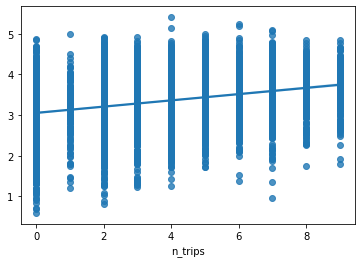

In [92]:
sns.regplot(y_test,LR_pred) #plotting predictions 

In [93]:
#calculate VIF scores to detect multicolinearity 

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i)
                          for i in range(len(x_train.columns))]
  
print(vif_data)

                            feature           VIF
0                           NUMADLT  3.003530e+01
1                        YOUNGCHILD  2.080213e+01
2                          WRKCOUNT  6.088579e+01
3                            EDUC_1  6.504786e+00
4                            EDUC_2  2.170220e+01
..                              ...           ...
110  YOUNGCHILD_ratio_more_than_0.5  3.408709e+07
111                WRKCOUNT_ratio_0  5.115950e+06
112                WRKCOUNT_ratio_1  9.847914e+06
113    WRKCOUNT_ratio_less_than_0.5  5.132278e+06
114    WRKCOUNT_ratio_more_than_0.5  1.795547e+06

[115 rows x 2 columns]


In [94]:
vif_data.sort_values(by = 'VIF', ascending = False)

,feature,VIF
97,AGE_bins_more_than_75,2.166041e+10
80,LIF_CYC_1,1.111889e+10
87,LIF_CYC_7,5.319992e+09
109,YOUNGCHILD_ratio_less_than_0.5,5.106464e+09
64,MSACAT_4,4.120796e+09
...,...,...
54,HHFAMINC_3,2.882586e+00
53,HHFAMINC_2,1.975825e+00
50,HHFAMINC_1,1.707033e+00
11,R_RACE_4,1.450180e+00


In [95]:
# counting number of infinity features 

vif_data_inf = np.isinf(vif_data['VIF']).values.sum()
print("It contains " + str(vif_data_inf) + " infinite values")

It contains 0 infinite values


In [96]:
#cross validation to see if it will improve results 

folds = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = model_selection.cross_val_score(LRmodel, x_train, y_train, scoring='neg_mean_squared_error', cv=folds)

print('\nR2 score:',scores)


R2 score: [-5.16669994 -5.0430599  -5.03798935 -5.10160311 -5.02936919]


In [97]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
scores

array([-5.166700, -5.043060, -5.037989, -5.101603, -5.029369])

In [ ]:
start_time = time.time()
from sklearn.feature_selection import RFE


#specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1,133))}]


# perform grid search

rfe = RFE(LRmodel)             

# 3.2 call GridSearchCV()
model_cv = model_selection.GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        verbose = 10,
                        return_train_score=True)      

# fit the model
model_cv.fit(x_train, y_train)   

print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

Fitting 5 folds for each of 132 candidates, totalling 660 fits
[CV 1/5; 1/132] START n_features_to_select=1....................................
[CV 1/5; 1/132] END n_features_to_select=1;, score=(train=-5.408, test=-5.579) total time=   3.6s
[CV 2/5; 1/132] START n_features_to_select=1....................................
[CV 2/5; 1/132] END n_features_to_select=1;, score=(train=-5.483, test=-5.418) total time=   3.4s
[CV 3/5; 1/132] START n_features_to_select=1....................................
[CV 3/5; 1/132] END n_features_to_select=1;, score=(train=-5.481, test=-5.427) total time=   3.9s
[CV 4/5; 1/132] START n_features_to_select=1....................................
[CV 4/5; 1/132] END n_features_to_select=1;, score=(train=-5.474, test=-5.525) total time=   3.7s
[CV 5/5; 1/132] START n_features_to_select=1....................................
[CV 5/5; 1/132] END n_features_to_select=1;, score=(train=-5.495, test=-5.424) total time=   3.7s
[CV 1/5; 2/132] START n_features_to_select

[CV 1/5; 10/132] END n_features_to_select=10;, score=(train=-5.392, test=-5.573) total time=   3.9s
[CV 2/5; 10/132] START n_features_to_select=10..................................
[CV 2/5; 10/132] END n_features_to_select=10;, score=(train=-5.437, test=-5.360) total time=   4.2s
[CV 3/5; 10/132] START n_features_to_select=10..................................
[CV 3/5; 10/132] END n_features_to_select=10;, score=(train=-5.383, test=-5.366) total time=   3.8s
[CV 4/5; 10/132] START n_features_to_select=10..................................
[CV 4/5; 10/132] END n_features_to_select=10;, score=(train=-5.469, test=-5.522) total time=   3.6s
[CV 5/5; 10/132] START n_features_to_select=10..................................
[CV 5/5; 10/132] END n_features_to_select=10;, score=(train=-5.459, test=-5.381) total time=   4.3s
[CV 1/5; 11/132] START n_features_to_select=11..................................
[CV 1/5; 11/132] END n_features_to_select=11;, score=(train=-5.391, test=-5.574) total time=   

In [ ]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

In [ ]:
# plotting cv results
plt.figure(figsize=(16,6))

#plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

#### 4.1.1.2 Linear Regression - Regularisation

**Lasso Regularisation**

In [ ]:
start_time = time.time()
alpha = [0.0001, 0.001, 0.005, 0.01]

for i in range(4):
    #build lasso regressor model here
    lasso = linear_model.Lasso(alpha=alpha[i])
    lasso.fit(x_train, y_train) #fit a lasso regression on the training data
    y_predlasso = lasso.predict(x_test) #use this model to predict the test data
    lasso_mse = metrics.mean_squared_error(y_test, y_predlasso) #calculate the test MSE
    lasso_rmse = metrics.mean_squared_error(y_test, y_predlasso,squared = False) #calculate the test RMSE
    msemanual = np.mean((y_predlasso-y_test)**2) #calculate mse manually to cross validate
    lasso_cplxy = (np.sum(abs(lasso.coef_))) #calculate l1norm / model complexity
    
    print('-' * 32)
    print('lasso with alpha', alpha[i])
    print('-' * 32)
    print('\nTrain score:', round(lasso.score(x_train, y_train), 3)) #compute train R^2 score
    print('Test score:', round(lasso.score(x_test, y_test), 3)) #compute test R^2 score
    print(list(map(lambda x: round(x, 3), lasso.coef_))) #list out the coef values 
    print('-' * 32)
    print('MSE on test set:', lasso_mse) #compute MSE results
    print('Manual MSE on test set:',msemanual) #compute MSE results
    print('RMSE on test set:', lasso_rmse) #compute RMSE results
    print('model complexity:', lasso_cplxy) #compute L1 NOMR score
    print('regularized cost:', lasso_mse + alpha[i] * lasso_cplxy) #compute regularised cost function scores
    print('\n')
print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))   

**Ridge Regularisation**

In [ ]:
start_time = time.time()
ridgealpha = [0.001, 0.01, 0.1, 1]

for i in range(4):
    #build ridge regressor here
    ridge = linear_model.Ridge(alpha=ridgealpha[i])
    ridge.fit(x_train, y_train) #fit a ridge regression on the training data
    y_pred_ridge = ridge.predict(x_test) #use this model to predict the test data
    ridge_mse = metrics.mean_squared_error(y_test, y_pred_ridge) #calculate the test mse
    ridge_rmse = metrics.mean_squared_error(y_test, y_pred_ridge,squared = False) #calculate the test rmse
    ridge_cplxy = (np.linalg.norm(ridge.coef_)) #calculate l2norm / model complexity
    
    print('-' * 32)
    print('ridge with alpha', ridgealpha[i])
    print('-' * 32)
    print('\nTrain score:', round(ridge.score(x_train, y_train), 3))
    print('Test score:', round(ridge.score(x_test, y_test), 3))
    print(list(map(lambda x: round(x, 3), ridge.coef_)))
    print('-' * 32)
    print('MSE on test set:', ridge_mse)
    print('RMSE on test set:', ridge_rmse)
    print('model complexity:', ridge_cplxy)
    print('regularized cost:', ridge_mse + ridgealpha[i] * ridge_cplxy)
    print('\n')
print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

### 4.1.1.3. Principal Component Regression

In [ ]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn import model_selection


In [ ]:
pca = PCA()
x_reduced = pca.fit_transform(scale(x_train))


In [ ]:
pd.DataFrame(pca.components_.T).loc[:4,:5]
#pd.DataFrame(pca.components_.T)

In [ ]:
# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=100) 

pcascores = model_selection.cross_val_score(LRmodel, x_reduced, y_train, scoring='neg_mean_squared_error', cv=kf_10)

print('\nR2 score:',pcascores)

In [ ]:
#specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1,109))}]
   

# GridSearchCV()
pcamodel_cv = model_selection.GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = kf_10, 
                        verbose = 10,
                        return_train_score=True)      

# fit the model
pcamodel_cv.fit(x_reduced, y_train)              

In [ ]:
pcacv_results = pd.DataFrame(pcamodel_cv.cv_results_)
pcacv_results

In [ ]:
# plotting cv results
plt.figure(figsize=(16,6))

#plt.plot(cv_results["param_n_features_to_select"], pcacv_results["mean_test_score"])
plt.plot(pcacv_results["param_n_features_to_select"], pcacv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

### 4.1.2. Ensemble Models

In [ ]:
def evaluate_model(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions-test_labels)
    mse = metrics.mean_squared_error(test_labels,predictions)
    rmse = np.sqrt(mse)
    
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    rsquare = model.score(test_features,test_labels)
    importance = model.feature_importances_

    
    print('Model Preformance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%,'.format(accuracy))
    print('rmse',rmse)
    print('mse',mse)
    print('R square:', rsquare)
    
    print("__________")
    print("Top 5 Features")
    feature_dict = {}
    for i,v in enumerate(importance):
        #print('Feature %0d, Score: %.5f' % (i,v))
        feature_dict[i]=v
    feature_names = test_features.columns
    sorted_features = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)
    
    for i in sorted_features[:5]:
        print(feature_names[i[0]],i[1])
        
    plt.bar([x for x in range(len(importance))],importance)
    plt.show()
    
    
    
    return accuracy

### 4.1.2.1. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_features': [27, 30, 33],
    'oob_score': [True],
    'n_estimators': [2250, 2500, 2750]
}
# Create a based model
rfgs = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfgs, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 3)
#wrapper_gs = RegressorChain(grid_search)
grid_search.fit(x_train, y_train)

#grid_search.fit(train_features, train_labels)
print(grid_search.best_params_)

print(grid_search.best_estimator_)
print(grid_search.best_score_)

y_pred_rfgs = grid_search.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfgs))
print("RMSE: %f" % (rmse))

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred_rfgs))
# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred_rfgs))

In [ ]:
best_rf = grid_search.best_estimator_
rf_accuracy = evaluate_model(best_rf, x_test, y_test)


### 4.1.2.2.Adaboost

In [ ]:
from sklearn import tree, ensemble, model_selection, metrics
from sklearn.model_selection import GridSearchCV

ada2=ensemble.AdaBoostRegressor(tree.DecisionTreeRegressor(), random_state = 888)

parameters ={
    'n_estimators':[350, 400, 500],
    'learning_rate':[0.01, 0.1],
    'base_estimator__max_depth':[25, 30, 35]
}

grid_ADA = GridSearchCV(estimator=ada2, param_grid=parameters, scoring='neg_mean_squared_error',n_jobs=-1, cv=3, verbose=3)
grid_ADA.fit(x_train, y_train)

 

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_ADA.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_ADA.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_ADA.best_params_)

#print("\n The best accuracy across ALL searched params:\n",evaluate(best_grid, x_test, y_test_one))

 

y_pred_ADA = grid_ADA.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ADA))
print("RMSE: %f" % (rmse))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_ADA))
# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred_ADA))

### 4.1.2.3. Gradient Boosting Regressor

In [ ]:
GBR = ensemble.GradientBoostingRegressor(random_state = 888)

parameters = {
    'learning_rate': [0.1, 0.2],
    'n_estimators' : [180, 200, 225],
    'max_depth'    : [5, 6, 8]
}

 

grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 3, n_jobs=-1, verbose = 3)
grid_GBR.fit(x_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

#print("\n The best accuracy across ALL searched params:\n",evaluate(best_grid, x_test, y_test_one))


y_pred_GBR = grid_GBR.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_GBR))

print("RMSE: %f" % (rmse))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_GBR))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.4f' % r2_score(y_test, y_pred_GBR))

## 4.1.2.4 XGBoost

In [ ]:
#pip install xgboost if yall need

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor


xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.001, 0.01, 0.03], #so called `eta` value
              'max_depth': [11,13,15],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [700, 800, 900]}

grid_xgb = GridSearchCV(estimator = xgb1,
                        param_grid = parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=3)

grid_xgb.fit(x_train,
         y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_xgb.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_xgb.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_xgb.best_params_)

#print("\n The best accuracy across ALL searched params:\n",evaluate(best_grid, x_test, y_test_one))


y_pred_xgb = grid_xgb.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("RMSE: %f" % (rmse))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_xgb))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.4f' % r2_score(y_test, y_pred_xgb))

### 4.1.3. Neural Network

In [ ]:
train_df = pd.concat([y_train,x_train], axis = 1)
test_df = pd.concat([y_test, x_train],axis =1)
test_df.rename(columns = {'HHSIZE_ above_3':'HHSIZE_above_3'} , inplace = True)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
from keras.layers import Dropout

In [ ]:
def create_model_deep(input_shape,learn_rate,dropout_rate, layers,kernel_reg): #name,my_feature_layer,dropout_rate, layers):
    model = tf.keras.models.Sequential()#name = name)
    model.add(tf.keras.Input(shape=(input_shape,)))
    #model.add(my_feature_layer)
    for index, layer in enumerate(layers):
        model.add(tf.keras.layers.Dense(units = layer,
                                        activation = 'relu',
                                        kernel_regularizer=kernel_reg,
                                        name=f'Hidden{index}'))
    model.add(Dropout(dropout_rate))  
    model.add(tf.keras.layers.Dense(units=1, name='Output'))  
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learn_rate),
                  loss="mean_squared_error",
                  metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [ ]:
one_hot_labs = [c for c in train_df if train_df[c].dtype == 'uint8']
num_labs = ['tier diff','bay diff','quantity','pos diff']

In [ ]:
feature_columns = []
for i in num_labs:
    i = tf.feature_column.numeric_column(i)
    feature_columns.append(i)
for k in one_hot_labs:
    k = tf.feature_column.numeric_column(k)
    feature_columns.append(k)
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [ ]:
import time
start_time = time.time()

input_shape = [x_train.shape[1]]
learn_rate = ((0.01),(0.1),(0.3))
batch_size = ((128,),(256,))
dropout_rate = ((0.1),(0),(0.2))
name = ['deep']
kernel_reg = ((tf.keras.regularizers.l2(0.04)),('glorot_uniform'))
layers = ((64,32,16,8),(64,16,8,4),(64,16),(64,32,16,8,4),(30,20,10,8))

 
param_grid = dict(input_shape = input_shape,
                  learn_rate = learn_rate,
                  dropout_rate = dropout_rate,
                  layers = layers,
                  kernel_reg = kernel_reg)

    
model_deep = KerasRegressor(build_fn = create_model_deep, epochs = 1000, batch_size = 256, verbose =2)
nn_grid = GridSearchCV(estimator = model_deep, param_grid = param_grid, n_jobs = -1, scoring='neg_mean_squared_error',verbose =5, cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 888))
nn_grid_result = nn_grid.fit(x_train, y_train)
best_nn = nn_grid.best_estimator_

print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



predictions = best_nn.predict(x_test)
mse = metrics.mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
rsquare = r2_score(y_test, predictions)

print('Model Preformance')
print('rmse',rmse)
print('mse',mse)
print('R square:', rsquare)

In [ ]:
nn_grid_result.best_params_

In [ ]:
# Create a table to compare the best results from X_train

| X_Train | Linear - Lasso | Ensemble - Random Forest | Nerual Network | 
|---|---|---|---|
| Parameters | 0 | 0 | 0 |
| MSE  | 0 | 0.0180 | 0.0420 |
| RMSE | 1.362 | 0.647 | 0 | 
| R-Square| 0.0172 | 0.0245 | 0.0420 | 
| Top Features| - | - | NA |

Overall best model is ___ for x_train dataset. However as model is week explore using trip distances

## 4.2. X_train_dist
X_train now to include the distances columns obtained from the trips data. Should there be improvement, would suggest that obtaining binned distance measures for different WHY categories would prove to aid the model better

In [ ]:
# run models with x_train_dist here - probably for each (linear vs ensemble vs nn) choose the best (E.G. run L2_linear, xgboost , NN )

### 4.2.1. Linear Models

#### 4.2.1.1. Linear Regression

In [ ]:
LRmodel_with_dist = linear_model.LinearRegression()  #create the linear regression 
LRmodel_with_dist.fit(x_train_with_dist,y_train) #train the model using the training set 
LR_pred_with_dist = LRmodel_with_dist.predict(x_test_with_dist) #use this model to predict the test data set 

In [ ]:
print('R^2 score:\t\t\t\t',LRmodel_with_dist.score(x_test_with_dist, y_test)) #compute R^2 score 
print('Explained Variance: \t\t\t', metrics.explained_variance_score(y_test, LR_pred_with_dist)) #compute explained variance score
print('Mean Absolute Error: \t\t\t', metrics.mean_absolute_error(y_test, LR_pred_with_dist)) #compute MAE results
print('Mean Squared Error:\t\t\t', metrics.mean_squared_error(y_test, LR_pred_with_dist)) #compute MSE results
print('Root Mean Squared Error:\t\t', metrics.mean_squared_error(y_test, LR_pred_with_dist, squared = False)) #compute RSME results
print('Intercept:\t', LRmodel_with_dist.intercept_) #find intercept value 
print('Coef:\t', np.sum(LRmodel_with_dist.coef_!=0))#find no of features used in regression model 

In [ ]:
sns.regplot(y_test,LR_pred_with_dist) #plotting predictions 

In [ ]:
#calculate VIF scores to detect multicolinearity 

# VIF dataframe
vif_data_with_dist = pd.DataFrame()
vif_data_with_dist["feature"] = x_train_with_dist.columns
  
# calculating VIF for each feature
vif_data_with_dist["VIF"] = [variance_inflation_factor(x_train_with_dist.values, i)
                          for i in range(len(x_train_with_dist.columns))]
  
print(vif_data_with_dist)

In [ ]:
vif_data_with_dist.sort_values(by = 'VIF', ascending = False)

In [ ]:
# counting number of infinity features 

vif_data_inf_with_dist = np.isinf(vif_data_with_dist['VIF']).values.sum()
print("It contains " + str(vif_data_inf_with_dist) + " infinite values")


In [ ]:
#cross validation to see if it will improve results 
folds = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 100)
scores_with_dist = model_selection.cross_val_score(LRmodel, x_train_with_dist, y_train, scoring='neg_mean_squared_error', cv=folds)
print('\nR2 score:',scores)

In [ ]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
scores_with_dist

In [ ]:
from sklearn.feature_selection import RFE
import time
start_time = time.time()
#specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1,109))}]


# perform grid search

rfe_with_dist = RFE(LRmodel_with_dist)             

# 3.2 call GridSearchCV()
model_cv_with_dist = model_selection.GridSearchCV(estimator = rfe_with_dist, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        verbose = 10,
                        return_train_score=True)      

# fit the model
model_cv_with_dist.fit(x_train_with_dist, y_train)
print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

In [ ]:
# cv results
cv_results_with_dist = pd.DataFrame(model_cv_with_dist.cv_results_)
cv_results_with_dist


In [ ]:
# plotting cv results
plt.figure(figsize=(16,6))

#plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results_with_dist["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')


#### 4.1.1.2 Linear Regression – Regularisation

**Lasso Regularisation**

In [ ]:
alpha = [0.0001, 0.001, 0.005, 0.01]

for i in range(4):
    #build lasso regressor model here
    lasso_with_dist = linear_model.Lasso(alpha=alpha[i])
    lasso_with_dist.fit(x_train_with_dist, y_train) #fit a lasso regression on the training data
    y_predlasso_with_dist = lasso_with_dist.predict(x_test_with_dist) #use this model to predict the test data
    lasso_mse_with_dist = metrics.mean_squared_error(y_test, y_predlasso_with_dist) #calculate the test MSE
    lasso_rmse_with_dist = metrics.mean_squared_error(y_test, y_predlasso_with_dist,squared = False) #calculate the test RMSE
    msemanual_with_dist = np.mean((y_predlasso_with_dist-y_test)**2) #calculate mse manually to cross validate
    lasso_cplxy_with_dist = (np.sum(abs(lasso_with_dist.coef_))) #calculate l1norm / model complexity
    
    print('-' * 32)
    print('lasso with alpha', alpha[i])
    print('-' * 32)
    print('\nTrain score:', round(lasso_with_dist.score(x_train_with_dist, y_train), 3)) #compute train R^2 score
    print('Test score:', round(lasso_with_dist.score(x_test_with_dist, y_test), 3)) #compute test R^2 score
    print(list(map(lambda x: round(x, 3), lasso_with_dist.coef_))) #list out the coef values 
    print('-' * 32)
    print('MSE on test set:', lasso_mse_with_dist) #compute MSE results
    print('Manual MSE on test set:',msemanual_with_dist) #compute MSE results
    print('RMSE on test set:', lasso_rmse_with_dist) #compute RMSE results
    print('model complexity:', lasso_cplxy_with_dist) #compute L1 NOMR score
    print('regularized cost:', lasso_mse_with_dist + alpha[i] * lasso_cplxy_with_dist) #compute regularised cost function scores
    print('\n')


**Ridge Regularisation**

In [ ]:
ridgealpha = [0.001, 0.01, 0.1, 1]

for i in range(4):
    #build ridge regressor here
    ridge_with_dist = linear_model.Ridge(alpha=ridgealpha[i])
    ridge_with_dist.fit(x_train_with_dist, y_train) #fit a ridge regression on the training data
    y_pred_ridge_with_dist = ridge_with_dist.predict(x_test_with_dist) #use this model to predict the test data
    ridge_mse_with_dist = metrics.mean_squared_error(y_test, y_pred_ridge_with_dist) #calculate the test mse
    ridge_rmse_with_dist = metrics.mean_squared_error(y_test, y_pred_ridge_with_dist,squared = False) #calculate the test rmse
    ridge_cplxy_with_dist = (np.linalg.norm(ridge_with_dist.coef_)) #calculate l2norm / model complexity
    
    print('-' * 32)
    print('ridge with alpha', ridgealpha[i])
    print('-' * 32)
    print('\nTrain score:', round(ridge_with_dist.score(x_train_with_dist, y_train), 3))
    print('Test score:', round(ridge_with_dist.score(x_test_with_dist, y_test), 3))
    print(list(map(lambda x: round(x, 3), ridge_with_dist.coef_)))
    print('-' * 32)
    print('MSE on test set:', ridge_mse_with_dist)
    print('RMSE on test set:', ridge_rmse_with_dist)
    print('model complexity:', ridge_cplxy_with_dist)
    print('regularized cost:', ridge_mse_with_dist + ridgealpha_with_dist[i] * ridge_cplxy_with_dist)
    print('\n')


### 4.2.1.3. Principal Component Regression

In [ ]:
pca_with_dist = PCA()
x_reduced_with_dist = pca_with_dist.fit_transform(scale(x_train_with_dist))

In [ ]:
pd.DataFrame(pca.components_.T).loc[:4,:5]
#pd.DataFrame(pca.components_.T)

In [ ]:
# 10-fold CV, with shuffle
kf_5 = model_selection.KFold(n_splits=5, shuffle=True, random_state=100)

pcascores_with_dist = model_selection_with_dist.cross_val_score(LRmodel, x_reduced_with_dist, y_train, scoring='neg_mean_squared_error', cv=kf_10)

print('\nR2 score:',pcascores_with_dist)


In [ ]:
#specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1,133))}]
   

# GridSearchCV()
pcamodel_cv_with_dist = model_selection.GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = kf_5, 
                        verbose = 10,
                        return_train_score=True)      

# fit the model
pcamodel_cv_with_dist.fit(x_reduced_with_dist, y_train)  


In [ ]:
pcacv_results_with_dist = pd.DataFrame(pcamodel_cv_with_dist.cv_results_)
pcacv_results_with_dist


In [ ]:
# plotting cv results
plt.figure(figsize=(16,6))

#plt.plot(cv_results["param_n_features_to_select"], pcacv_results["mean_test_score"])
plt.plot(pcacv_results_with_dist["param_n_features_to_select"], pcacv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')


In [ ]:
plt.plot(np.cumsum(pca_with_dist.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')


### 4.2.2.1. Random Forest

In [ ]:

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_features': [27, 30, 33],
    'oob_score': [True],
    'n_estimators': [2250, 2500, 2750]
}
# Create a based model
rfgs = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfgs, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 3)
#wrapper_gs = RegressorChain(grid_search)
grid_search.fit(x_train_with_dist, y_train)

#grid_search.fit(train_features, train_labels)
print(grid_search.best_params_)

print(grid_search.best_estimator_)
print(grid_search.best_score_)

y_pred_rfgs = grid_search.predict(x_test_with_dist)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfgs))
print("RMSE: %f" % (rmse))

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred_rfgs))
# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred_rfgs))

In [ ]:
best_rf = grid_search.best_estimator_
rf_accuracy = evaluate_model(best_rf, x_test_with_dist, y_test)

### 4.2..2. Adaboost

In [ ]:
ada2=ensemble.AdaBoostRegressor(tree.DecisionTreeRegressor(), random_state = 888)

parameters ={
    'n_estimators':[350, 400, 500],
    'learning_rate':[0.01, 0.1],
    'base_estimator__max_depth':[25, 30, 35]
}

grid_ADA = GridSearchCV(estimator=ada2, param_grid=parameters, scoring='neg_mean_squared_error',n_jobs=-1, cv=3, verbose=3)
grid_ADA.fit(x_train_with_dist, y_train)

 
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_ADA.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_ADA.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_ADA.best_params_)
#print("\n The best accuracy across ALL searched params:\n",evaluate(best_grid, x_test, y_test_one))

 
y_pred_ADA = grid_ADA.predict(x_test_with_dist)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ADA))
print("RMSE: %f" % (rmse))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_ADA))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred_ADA))

### 4.2.3. Gradient Boosting Regressor

In [ ]:
GBR = ensemble.GradientBoostingRegressor(random_state = 888)

parameters = {
    'learning_rate': [0.1, 0.2],
    'n_estimators' : [180, 200, 225],
    'max_depth'    : [5, 6, 8]
}

 
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 3, n_jobs=-1, verbose = 3)
grid_GBR.fit(x_train_with_dist, y_train)


print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)
#print("\n The best accuracy across ALL searched params:\n",evaluate(best_grid, x_test, y_test_one))
 

y_pred_GBR = grid_GBR.predict(x_test_with_dist)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_GBR))

print("RMSE: %f" % (rmse))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_GBR))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.4f' % r2_score(y_test, y_pred_GBR))

### 4.2.4. XGBoost

In [ ]:

xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.001, 0.01, 0.03], #so called `eta` value
              'max_depth': [11,13,15],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [700, 800, 900]}

grid_xgb = GridSearchCV(estimator = xgb1,
                        param_grid = parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=3)

grid_xgb.fit(x_train_with_dist,
         y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_xgb.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_xgb.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_xgb.best_params_)

#print("\n The best accuracy across ALL searched params:\n",evaluate(best_grid, x_test, y_test_one))


y_pred_xgb = grid_xgb.predict(x_test_with_dist)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("RMSE: %f" % (rmse))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_xgb))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.4f' % r2_score(y_test, y_pred_xgb))

### 4.2.3. Neural Network

In [ ]:
#use the same param_grid as earlier

start_time = time.time()

input_shape = [x_train_with_dist.shape[1]]
learn_rate = ((0.01),(0.1),(0.3))
batch_size = ((128,),(256,))
dropout_rate = ((0.1),(0),(0.2))
name = ['deep']
kernel_reg = ((tf.keras.regularizers.l2(0.04)),('glorot_uniform'))
layers = ((64,32,16,8),(64,16,8,4),(64,16),(64,32,16,8,4),(30,20,10,8))

 
param_grid = dict(input_shape = input_shape,
                  learn_rate = learn_rate,
                  dropout_rate = dropout_rate,
                  layers = layers,
                  kernel_reg = kernel_reg)

    
model_deep = KerasRegressor(build_fn = create_model_deep, epochs = 1000, batch_size = 256, verbose =2)
nn_grid = GridSearchCV(estimator = model_deep, param_grid = param_grid, n_jobs = -1, scoring='neg_mean_squared_error',verbose =5, cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 888))
nn_grid_result = nn_grid.fit(x_train_with_dist, y_train)
best_nn = nn_grid.best_estimator_

print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



predictions = best_nn.predict(x_test_with_dist)
mse = metrics.mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
rsquare = r2_score(y_test, predictions)

print('Model Preformance')
print('rmse',rmse)
print('mse',mse)
print('R square:', rsquare)

In [ ]:
nn_grid_result.best_params_

| X_Train_with_dist | Linear - Lasso | Ensemble - Random Forest | Nerual Network | 
|---|---|---|---|
| MSE  | 0 | 0.0180 | 2.49 |
| RMSE | 1.362 | 0.647 | 1.58 | 
| R-Square| 0.0172 | 0.0245 | 0.55 | 
|Top Features | - | - | NA|

Overall, adding distance features improved all models significantly and hence reccommendation is for future surveys to add in questions regarding main why column to ask distance bins.

e.g. select from bins the distance to workplace for each member of the family 
